ИВАНОВ АРТЕМ 6132 MatMul

Validation passed
Matrix: 200x200, CPU time: 7.5298s, GPU time: 0.0004s
Validation passed
Matrix: 300x300, CPU time: 27.0297s, GPU time: 0.0007s
Validation passed
Matrix: 500x500, CPU time: 125.4698s, GPU time: 0.0024s
Validation passed
Matrix: 800x800, CPU time: 519.7504s, GPU time: 0.0060s
Validation passed
Matrix: 1100x1100, CPU time: 1345.3106s, GPU time: 0.0135s
Ускорение gpu над cpu для размера: 200 - 16790.23870281765
Ускорение gpu над cpu для размера: 300 - 38772.49692202462
Ускорение gpu над cpu для размера: 500 - 51715.670892295595
Ускорение gpu над cpu для размера: 800 - 86807.28104965556
Ускорение gpu над cpu для размера: 1100 - 99809.69998584922


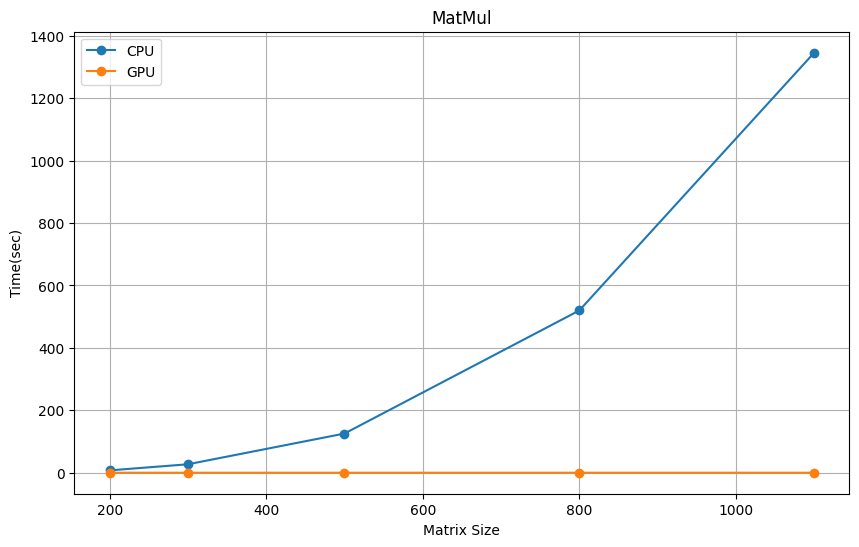

In [18]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt

# CUDA kernel in C++
kernel = cp.RawKernel(r'''
extern "C" __global__
void matmul(float* A, float* B, float* C, int N, int M, int K) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < K) {
        float value = 0.0f;
        for (int i = 0; i < M; i++) {
            value += A[row * M + i] * B[i * K + col];
        }
        C[row * K + col] = value;
    }
}
''', 'matmul')


def gen_matrix(size):
    return np.random.rand(size, size).astype(np.float32)


#GPU
def multiply_matrices_gpu(A, B):
    N, M = A.shape
    M, K = B.shape

    A_gpu = cp.asarray(A)
    B_gpu = cp.asarray(B)
    C_gpu = cp.zeros((N, K), dtype=cp.float32)

    block_size = (16, 16)
    grid_size = ((K + block_size[0] - 1) // block_size[0], (N + block_size[1] - 1) // block_size[1])

    kernel(grid_size, block_size, (A_gpu, B_gpu, C_gpu, N, M, K))


    return cp.asnumpy(C_gpu)



#CPU
def multiply_matrices_cpu(A, B):
    rows_A = len(A)
    cols_A = len(A[0])
    rows_B = len(B)
    cols_B = len(B[0])

    if cols_A != rows_B:
        raise ValueError("Неподходящие размеры для умножения.")

    result = np.zeros((rows_A, cols_B))

    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                result[i][j] += A[i][k] * B[k][j]

    return result

def test_cpu(A, B):
    start = time.time()
    result = multiply_matrices_cpu(A, B)
    end = time.time()
    return result, end - start

def test_gpu(A, B):
    start = time.time()
    result = multiply_matrices_gpu(A, B)
    cp.cuda.Stream.null.synchronize()
    end = time.time()
    return result, end - start

#validation
def validation(cpu_result, gpu_result):
    return np.allclose(cpu_result, cp.asnumpy(gpu_result))

def main(sizes):
    time_cpu = []
    time_gpu = []
    for size in sizes:
        A_cpu = gen_matrix(size)
        B_cpu = gen_matrix(size)

        A_gpu = cp.asarray(A_cpu)
        B_gpu = cp.asarray(B_cpu)

        cpu_result, cpu_time = test_cpu(A_cpu, B_cpu)
        time_cpu.append(cpu_time)

        gpu_result, gpu_time = test_gpu(A_gpu, B_gpu)
        time_gpu.append(gpu_time)

        if(validation(cpu_result, gpu_result)):
          print("Validation passed")
        else:
          print("Error with size of matrix")


        print(f"Matrix: {size}x{size}, CPU time: {cpu_time:.4f}s, GPU time: {gpu_time:.4f}s")

    return time_cpu, time_gpu



def plot(sizes, time_cpu, time_gpu):
    speedup = [cpu/gpu for cpu, gpu in zip(time_cpu, time_gpu)]
    for i in range(len(sizes)):
      print(f"Ускорение gpu над cpu для размера: {sizes[i]} - {speedup[i]}")

    plt.figure(figsize=(10, 6))
    plt.plot(sizes, time_cpu, label="CPU", marker='o')
    plt.plot(sizes, time_gpu, label="GPU", marker='o')

    plt.xlabel("Matrix Size")
    plt.ylabel("Time(sec)")
    plt.title("MatMul")
    plt.legend()
    plt.grid(True)
    plt.show()



sizes = [200, 300, 500, 800, 1100]
time_cpu, time_gpu = main(sizes)
plot(sizes, time_cpu, time_gpu)